In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from PIL import Image
from pathlib import Path
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion, closing, square
import operator

In [2]:
def gut_thresholding(file):
    """
    Applies RAG thresholding to the specified file, and returns a numpy array of the threshholded grayscale image.
    """
    img = cv2.imread(file)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    return thresh

In [3]:
def foreground(file):
    """
    Using the output of the gut_thresholding function above, identifies the "foreground" of an image, to be used in 
    further iterations of the RAG process below.
    """
    
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(gut_thresholding(file),cv2.MORPH_OPEN,kernel, iterations = 2)

    sure_bg = cv2.dilate(opening,kernel,iterations=3)

    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

    sure_fg = np.uint8(sure_fg)

    return sure_fg

In [4]:
def unknown(file):
    """
    Using the output of the foreground function above, identifies the "unknown" regions of an image, that cannot be
    identified as either foreground or background. These regions will be used in further iterations of the RAG 
    process below.
    """
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(gut_thresholding(file),cv2.MORPH_OPEN,kernel, iterations = 2)

    sure_bg = cv2.dilate(opening,kernel,iterations=3)

    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

    sure_fg = np.uint8(sure_fg)

    unknown = cv2.subtract(sure_bg,sure_fg)
    return unknown

In [5]:
def markers(file):
    """
    Using the output of the foreground and unknown functions above, identifies areas of "regional adjacency", and marks
    those regions with a unique interger that is entered at the specified pixel location in the numpy array generated.
    The numpy array returned is in the shape of the original image, and contains only the markers for each identified 
    region.
    """
    ret, markers = cv2.connectedComponents(foreground(file))

    markers = markers+1
    markers[unknown(file)==255] = 0

    img = cv2.imread(file)
    markers = cv2.watershed(img,markers)
    img[markers == -1] = [255,0,0]
    return markers

In [6]:
def gut_mask(file, regions):
    """
    This function uses the markers generated in the markers function to mask all regions specified in "regions" input for
    this function. It is currently a weakness of this function that it is unable to automatically identify the desired
    regions to be masked, and at this time they must be specified based on a visual inspection of the markers when
    compared to the original image.
    """
    marks = markers(file)
    mask = np.zeros(marks.shape[:2],dtype=np.bool)
    
    for i in range(marks.shape[0]):
        for j in range(marks.shape[1]):
            if marks[i][j] in regions:
                mask[i,j] = True
            
    return mask

In [7]:
def mask_stack(directory, regions):
    """
    This function uses a daisychain of all the previous functions to identify the desired mask using the first image
    in the directory, and then apply the mask to all subsequent images stored at the specified directory. This matches
    the format in which the HTP lightsheet microscope currently saves images.
    """
    pathlist = Path(directory).glob('**/*.tif')
    
    n = 0    
    for file in pathlist:
        if n == 0:
            demo = np.array(Image.open(str(file)))
            plt.imshow(demo,cmap="gray")
            plt.show()
            mask = gut_mask(str(file), regions)
            n+=1
        img = np.array(Image.open(file))
        img[mask] = 8700
        plt.imshow(img,cmap="gray")
        plt.show()

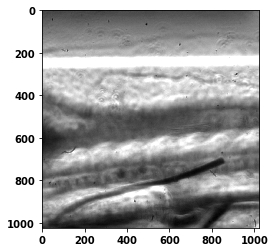

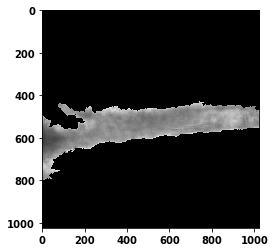

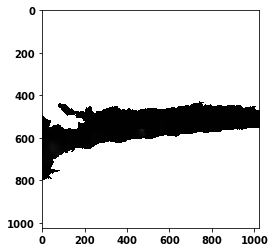

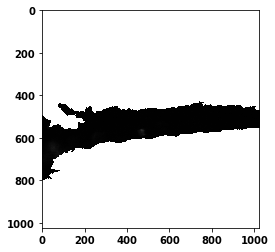

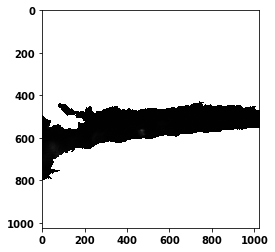

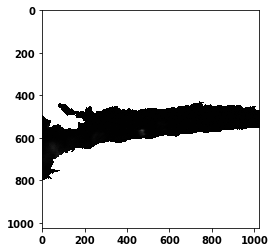

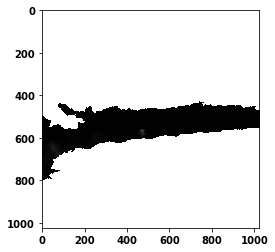

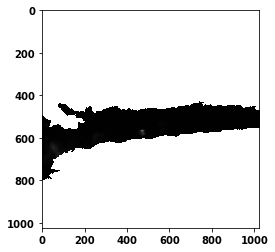

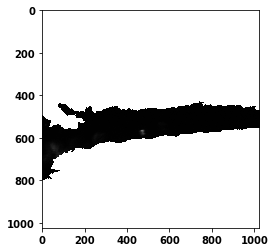

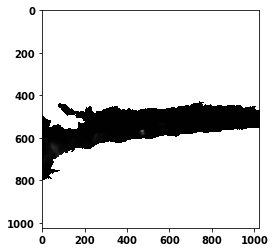

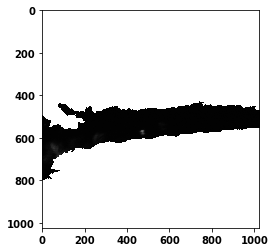

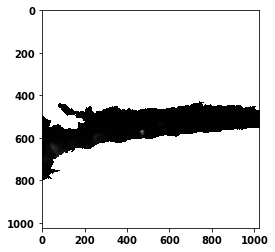

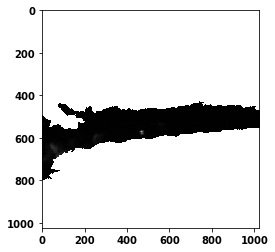

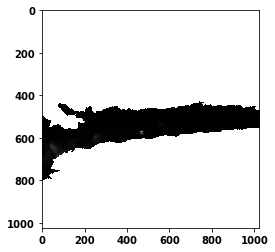

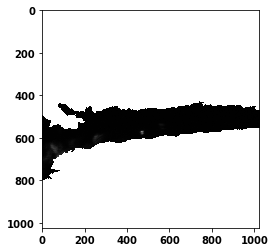

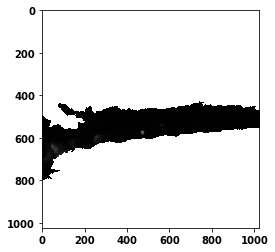

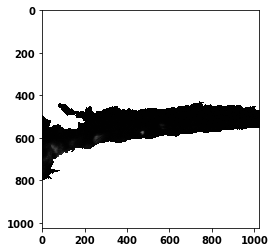

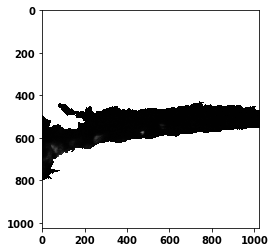

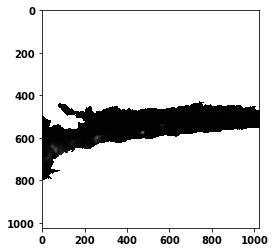

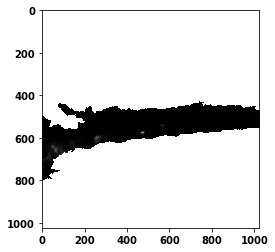

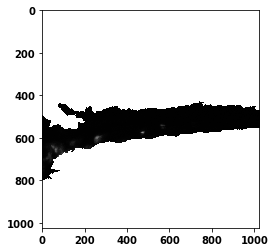

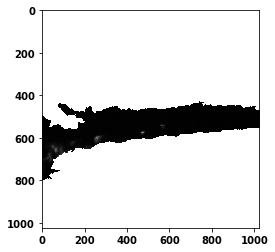

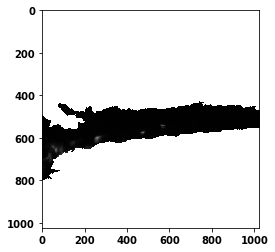

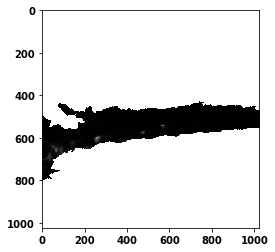

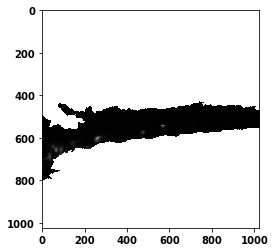

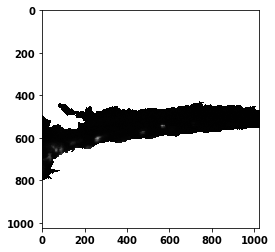

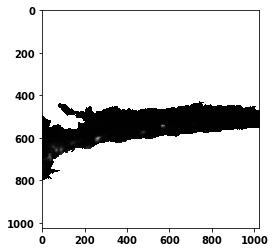

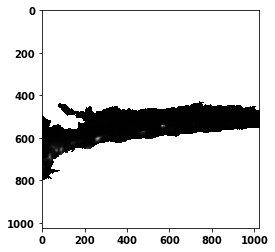

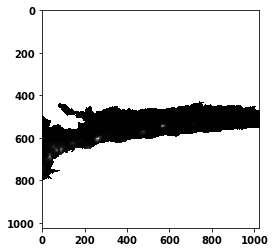

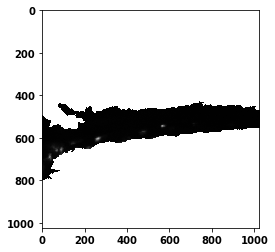

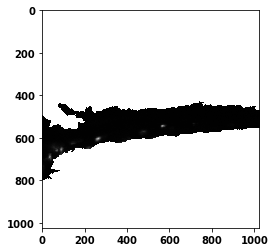

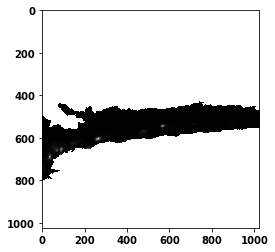

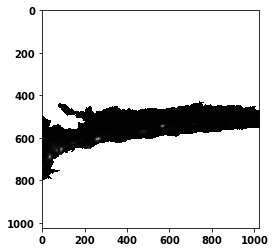

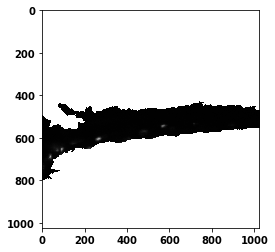

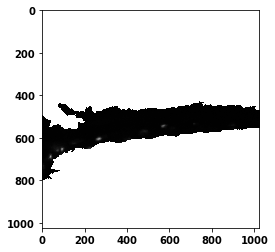

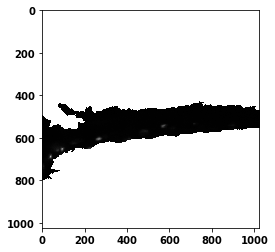

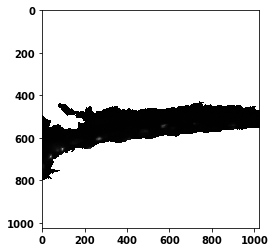

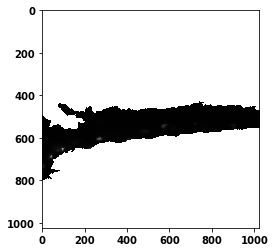

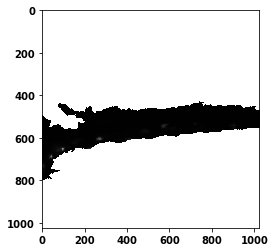

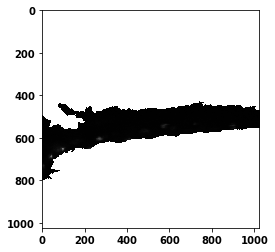

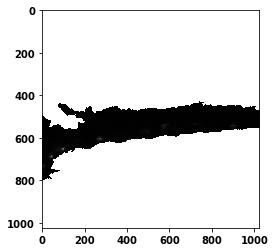

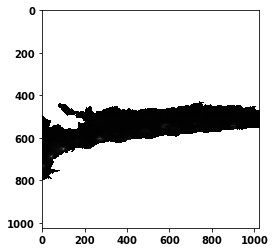

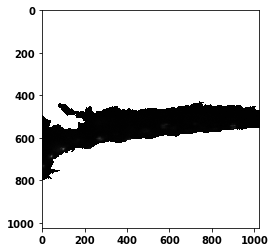

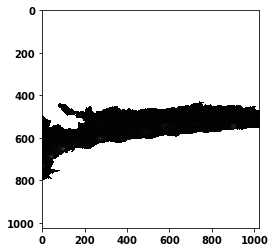

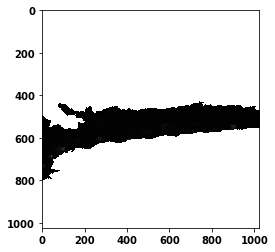

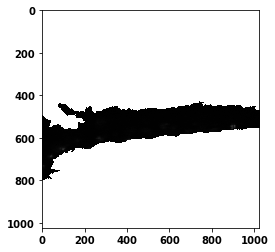

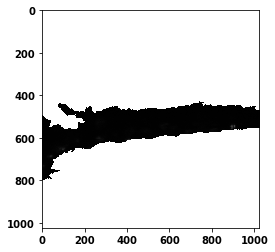

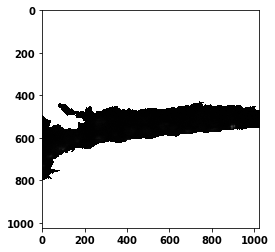

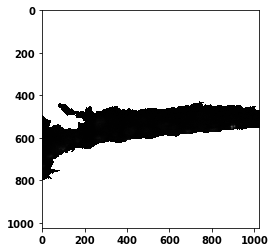

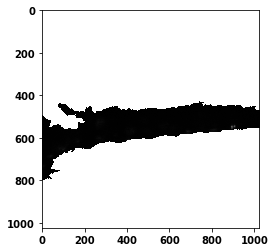

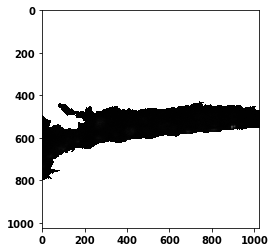

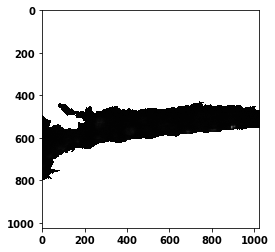

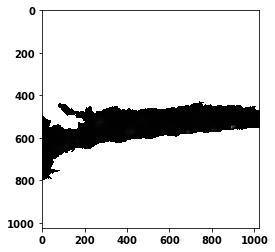

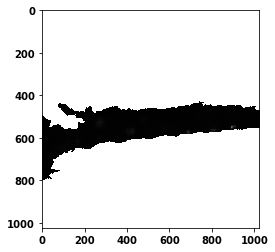

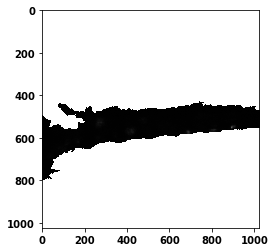

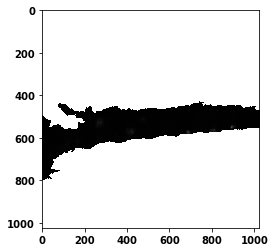

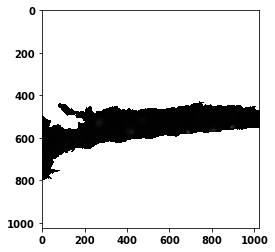

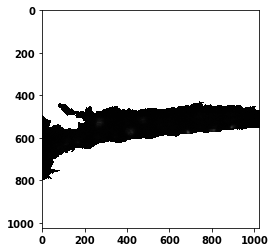

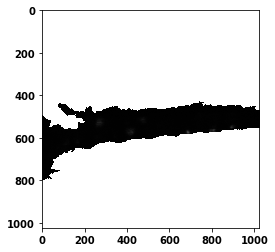

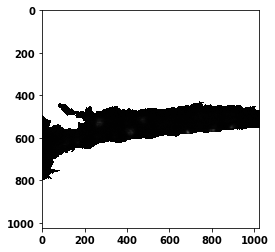

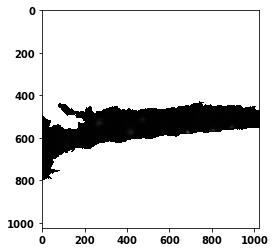

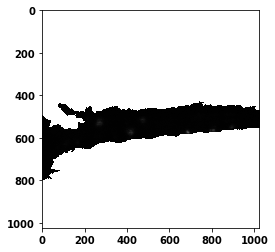

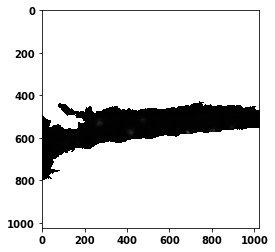

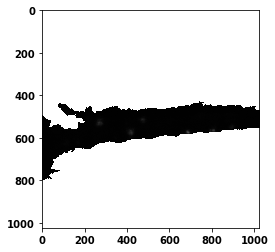

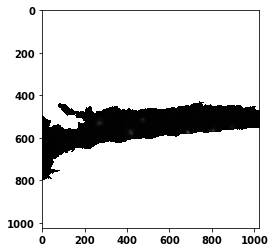

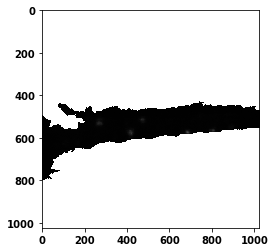

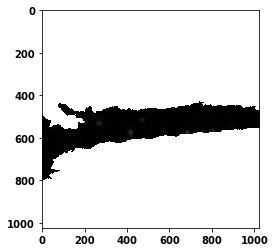

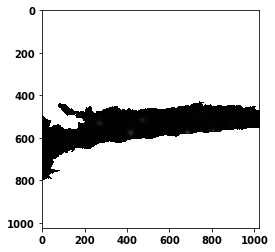

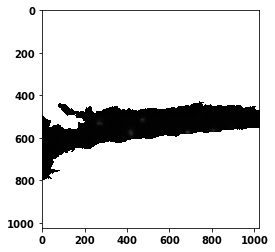

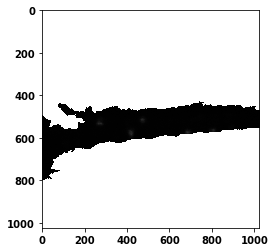

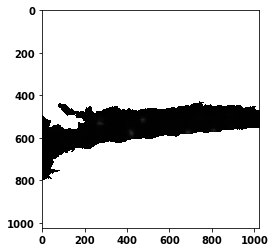

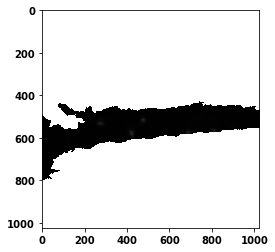

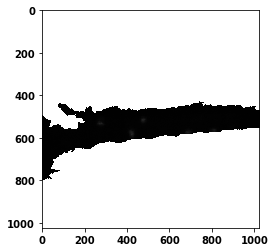

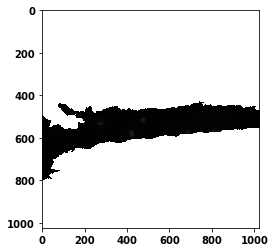

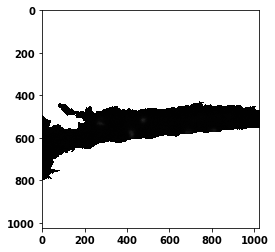

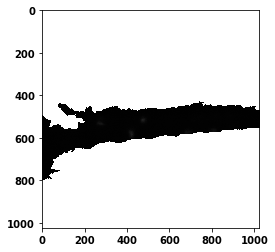

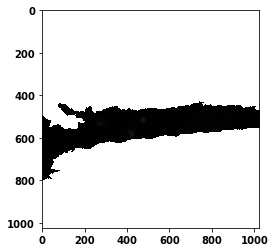

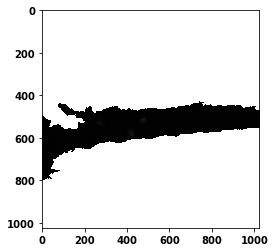

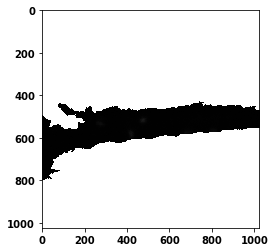

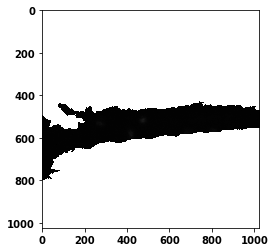

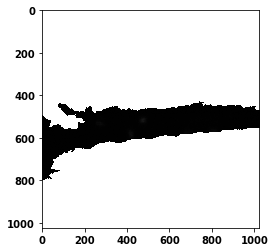

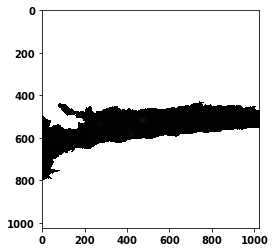

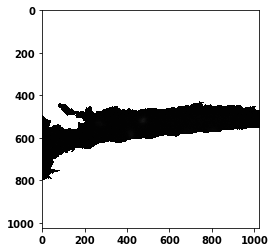

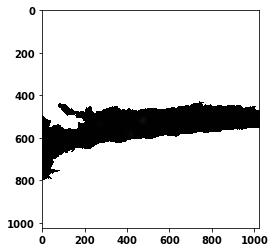

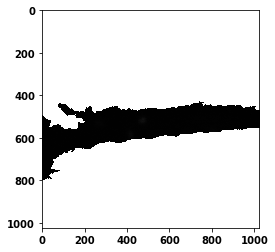

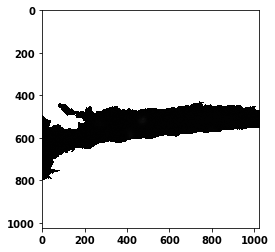

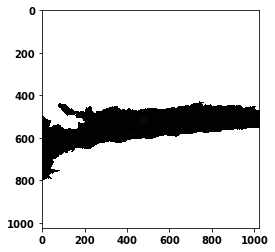

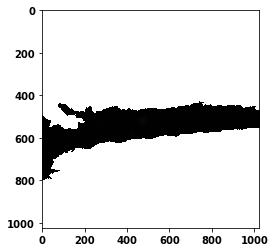

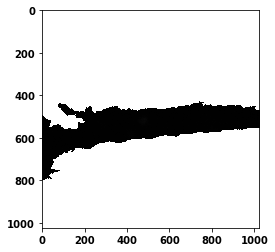

In [8]:
regions = [1,2,4,-1]
mask_stack("data_files", regions)

In [9]:
def initial_thresholding(images, thresh, min_box_allowed1):
    '''
    Takes in your 3D image stack and does simple initial thresholding, then uses sci-kit image's regionprops to find a
    list of your potential neutrophil.
    :param images: 3D image stack
    :param thresh: Pixel thresholding value
    :param min_box_allowed1: Each dimension of bounding box of potential neutrophil must be greater than this length.
    :return: labeled regionprops that are your potential neutrophil (neuts).
    '''
    binarized = [binary_erosion(closing(image, square(3)) > thresh) for image in images]
    labeled = label(np.array(binarized))
    props = regionprops(labeled)
    neuts = []
    for i in range(len(props)):
        if all(np.array(np.shape(props[i].image)) > min_box_allowed1):
            neuts.append(props[i])
    return neuts


def shrinking_boxes(images, neuts, min_box_allowed2, min_area_allowed, min_area_to_shrink):
    '''
    This is a function that takes in your 3D image stack, and your labeled regionprops that are your potential
    neutrophils (neuts), then, for each potential neutrophil, this re-segments that object according to a new
    thresholding based on Otsu thresholding, basic morphological operations and tests to see if the object fits within
    specified parameters of what should be considered a neutrophil. Returns labeled regionprops of pruned potential
    neutrophil (neuts).
    :param images: 3D image stack
    :param neuts: regionprops of potential neutrophil, see sci-kit image for documentation on regionprops
    :param min_box_allowed2: Each dimension of bounding box of potential neutrophil must be greater than this length.
    :param min_area_allowed: minimum total number of pixels allowed to be considered a neutrophil
    :param min_area_to_shrink: If regionprop is smaller than this, do not re-threshold.
    :return: labeled regionprops that are your potential neutrophil (neuts).
    '''
    new_mask = np.zeros(np.shape(images))
    for i in neuts:
        (z_start, y_start, x_start, z_end, y_end, x_end) = i.bbox
        neut_sub_image = np.array(images)[z_start:z_end, y_start:y_end, x_start:x_end]
        thresh_sub_image = threshold_otsu(neut_sub_image)
        if i.area < min_area_to_shrink:
            neut_sub_mask = np.array(neut_sub_image > thresh_sub_image)
        else:
            neut_sub_mask = np.array(binary_erosion(neut_sub_image > thresh_sub_image))
        props_sub_images = regionprops(label(neut_sub_mask))
        for el in props_sub_images:
            (z_start, y_start, x_start) = tuple(map(operator.add, i.bbox[:3], el.bbox[:3]))
            (z_end, y_end, x_end) = tuple(map(operator.add, i.bbox[:3], el.bbox[-3:]))
            new_mask[z_start:z_end, y_start:y_end, x_start:x_end] = el.image
    labeled = label(np.array(new_mask))
    props = regionprops(labeled)
    neuts = []
    for i in range(len(props)):
        if all(np.array(np.shape(props[i].image)) > min_box_allowed2) and props[i].area > min_area_allowed:
            neuts.append(props[i])
    return neuts


def mean_sem(dataset):
    return [np.round(np.mean(dataset), 2), np.round(np.std(dataset)/len(dataset), 2)]


#  The following is a list of each parameter that is fed in to your iterative thresholding functions below.
# Median Params for data 9/17/2019 = [849, 3, 3, 16, 7627]
thresh = 849
n = 3
m = 3
min_area_allowed = 16
min_area_to_shrink = 7627
shrink_iterations = 3
min_box_allowed1 = [n, 2*n, 2*n]
min_box_allowed2 = [m, 2*m, 2*m]



neuts = initial_thresholding(images, thresh, min_box_allowed1)
### ITERATIVE THRESHOLDING USING SHRINKING BOXES
for j in range(shrink_iterations):
    neuts = shrinking_boxes(images, neuts, min_box_allowed2, min_area_allowed, min_area_to_shrink)

print(str(len(neuts)) + ' total neutrophil')  # total number of neutrophil
xyzs = [i.centroid for i in neuts]  # centroid location in pixels for each of the found neutrophil

NameError: name 'images' is not defined